In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

In [2]:
import charset_normalizer

path = './data/vitivinicultura.csv'
with open(path, 'rb') as rd:
    result = charset_normalizer.detect(rd.read(110000))
    print('encoding: ', result['encoding'])
    rd.close()
df = pd.read_csv(path, encoding=result['encoding'])
df.head()

encoding:  windows-1250


,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
0,13,Vitivinicultura,162,Mosto,Elaboración,hl,INV,Anual,Nacional,PROVINCIA,10,CATAMARCA,2002-01-01,4079.0
1,13,Vitivinicultura,162,Mosto,Elaboración,hl,INV,Anual,Nacional,PROVINCIA,10,CATAMARCA,2003-01-01,6126.0
2,13,Vitivinicultura,162,Mosto,Elaboración,hl,INV,Anual,Nacional,PROVINCIA,10,CATAMARCA,2004-01-01,17905.0
3,13,Vitivinicultura,162,Mosto,Elaboración,hl,INV,Anual,Nacional,PROVINCIA,10,CATAMARCA,2005-01-01,33147.0
4,13,Vitivinicultura,162,Mosto,Elaboración,hl,INV,Anual,Nacional,PROVINCIA,10,CATAMARCA,2006-01-01,52299.0


In [3]:
df['indice_tiempo'].sort_values(ascending=False).head(10)

7580    2024-09-01
8435    2024-09-01
2469    2024-09-01
7865    2024-09-01
7046    2024-09-01
6293    2024-09-01
6536    2024-09-01
3198    2024-09-01
3768    2024-09-01
6032    2024-09-01
Name: indice_tiempo, dtype: object

In [4]:
df.isnull().sum()

sector_id                    0
sector_nombre                0
variable_id                  0
actividad_producto_nombre    0
indicador                    0
unidad_de_medida             0
fuente                       0
frecuencia_nombre            0
cobertura_nombre             0
alcance_tipo                 0
alcance_id                   0
alcance_nombre               0
indice_tiempo                0
valor                        7
dtype: int64

In [5]:
df = df.dropna()
df = df.drop(df[df['alcance_nombre'] == 'INDETERMINADA'].index) 
df['fecha'] = pd.to_datetime(df['indice_tiempo'], format='%Y-%m-%d')
df_regiones = df.copy()
df_regiones = df_regiones[df_regiones['alcance_nombre'] != 'Argentina'] 

In [6]:
d = ['Elaboración', 'Exportaciones', 'Producción', 'Mercado interno']
for i in d:
    print(df[df['indicador'] == i].shape)
    print(df[df['indicador'] == i]['frecuencia_nombre'].unique())
    print(df[df['indicador'] == i]['cobertura_nombre'].unique())
    print(df[df['indicador'] == i]['alcance_tipo'].unique())
    print(df[df['indicador'] == i]['unidad_de_medida'].unique())
    print('----------')

(526, 15)
['Anual']
['Nacional']
['PROVINCIA']
['hl']
----------
(7183, 15)
['Anual' 'Mensual']
['Nacional']
['PAIS' 'PROVINCIA']
['miles de dólares' 'tn' 'hl']
----------
(27, 15)
['Anual']
['Nacional']
['PAIS']
['tn']
----------
(3868, 15)
['Anual' 'Mensual']
['Nacional']
['PROVINCIA']
['hl']
----------


In [7]:
noa = ['CATAMARCA', 'SALTA', 'JUJUY', 'TUCUMAN', 'SANTIAGO DEL ESTERO']
nea = ['MISIONES', 'CORRIENTES', 'CHACO']
cuyo = ['SAN LUIS', 'LA RIOJA']
mendoza_y_sanjuan = ['MENDOZA', 'SAN JUAN']
centro = ['CORDOBA', 'SANTA FE', 'ENTRE RIOS', 'BUENOS AIRES']
patagonia = ['RIO NEGRO', 'LA PAMPA', 'SANTA CRUZ', 'CHUBUT', 'NEUQUEN']
regiones = [noa, nea, cuyo, mendoza_y_sanjuan, centro, patagonia]
nombre_regiones = ['NOA', 'NEA', 'CUYO', 'MENDOZA-SANJUAN', 'CENTRO', 'PATAGONIA']

In [8]:
def set_regions(provincia):
    for i in range(len(regiones)):
        if provincia in regiones[i]:
            return nombre_regiones[i]

df_regiones['region'] = df_regiones['alcance_nombre'].apply(lambda row: set_regions(row))

# Regiones tomadas en cuenta:
- Region Noa
- Region Nea
- Region Centro (Buenos Aires Está incluido aquí por motivos de simplicidad)
- Region Cuyo
- Mendoza y San Juan (se toman en cuenta aparte debido a la gran diferencia contra el resto de provincias)
- Region Patagonia

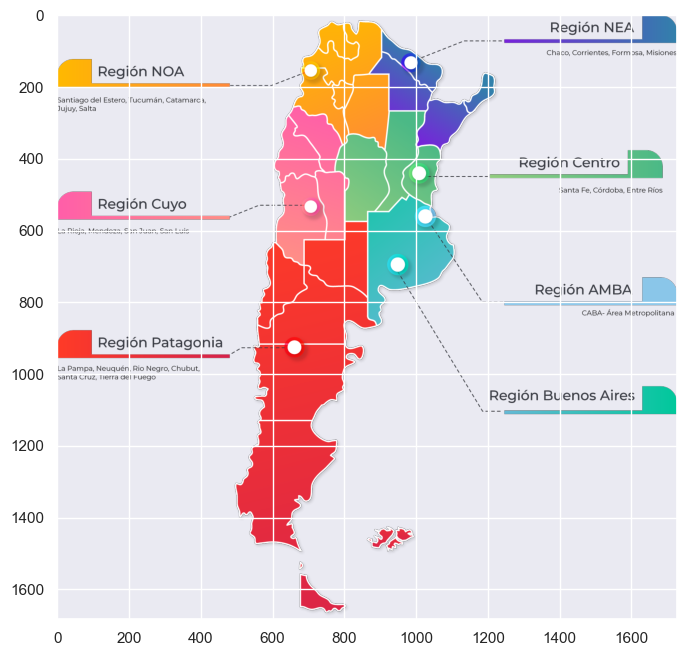

In [9]:
import matplotlib.image as mpimg
img = mpimg.imread('regiones.png')
imgplot = plt.imshow(img)
imgplot.figure.set_size_inches(8,8)
plt.show()


In [10]:
df_elab = df_regiones[df_regiones['indicador'] == 'Elaboración']
df_exp = df_regiones[(df_regiones['indicador'] == 'Exportaciones') & (df_regiones['frecuencia_nombre'] == 'Mensual')]
df_exp_md = df_exp[df_exp['unidad_de_medida']=='miles de dólares']
df_exp_hl = df_exp[df_exp['unidad_de_medida']=='hl']
df_prod = df[df['indicador'] == 'Producción']
df_int = df_regiones[(df_regiones['indicador'] == 'Mercado interno') & (df['frecuencia_nombre'] == 'Mensual')]

C:\Users\nico\AppData\Local\Temp\ipykernel_7676\2953071632.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_int = df_regiones[(df_regiones['indicador'] == 'Mercado interno') & (df['frecuencia_nombre'] == 'Mensual')]


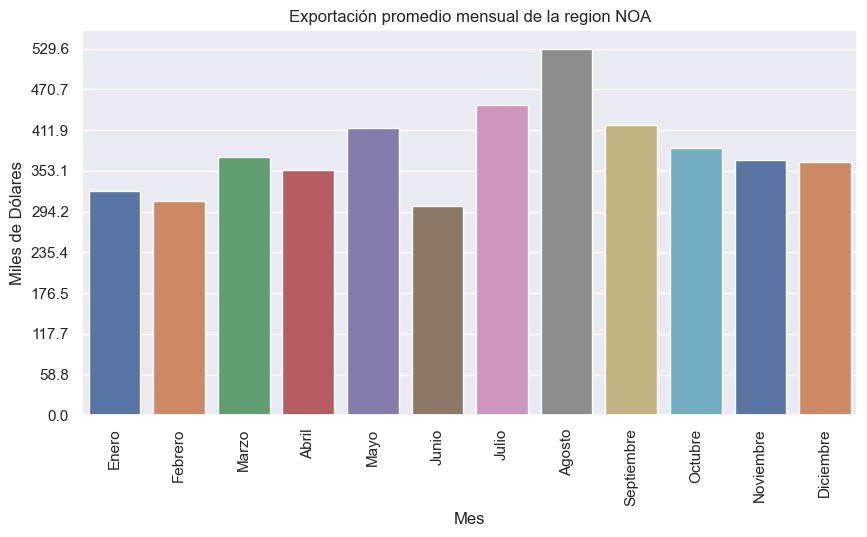

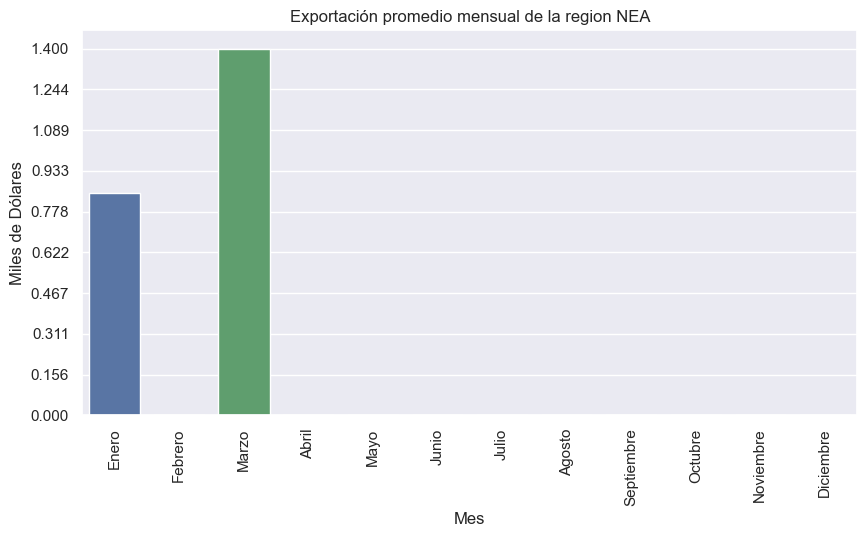

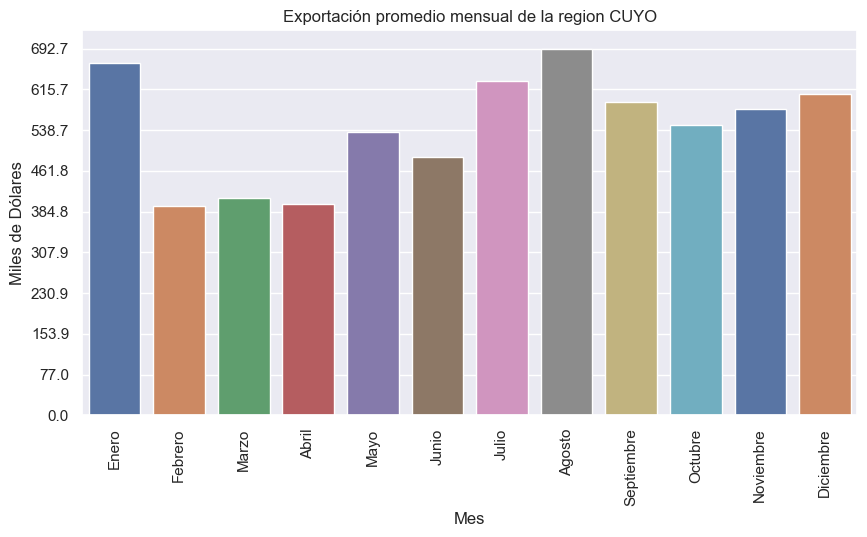

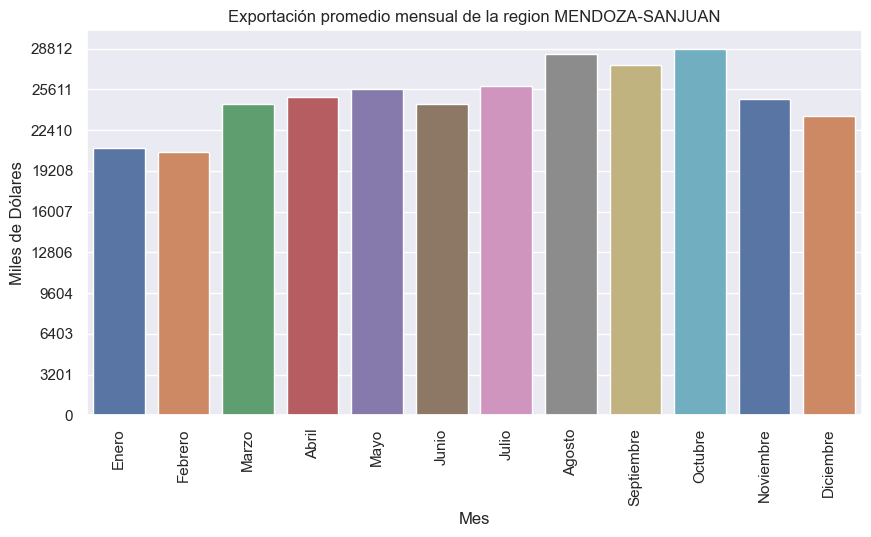

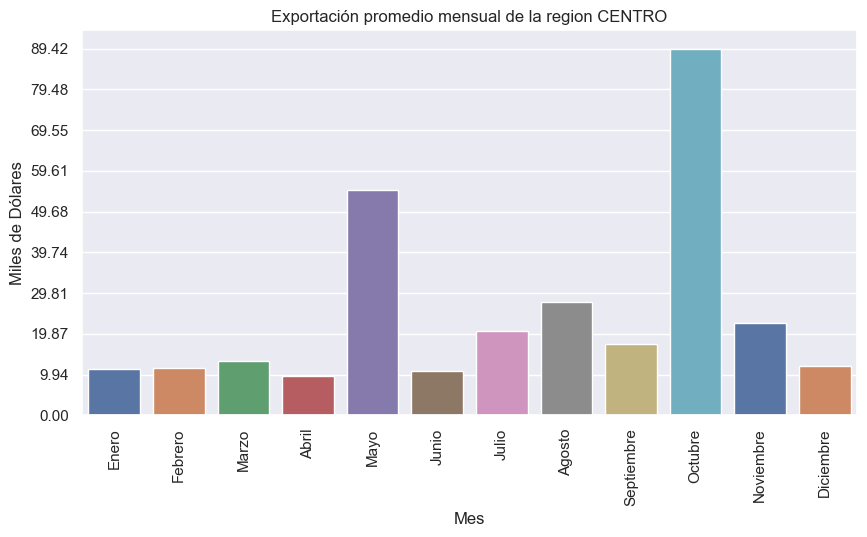

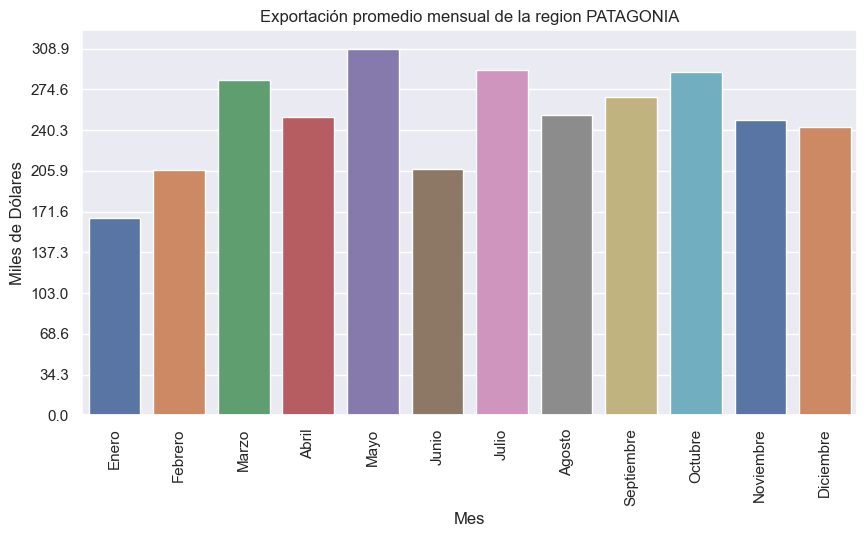

In [11]:
for a in range(len(regiones)):
    exp_provs = df_exp_md[df_exp_md['region'] == nombre_regiones[a]]
    mean_exp_per_month = exp_provs.groupby(exp_provs['fecha'].dt.month)['valor'].mean()
    mean_exp_per_month.index = mean_exp_per_month.index.map({1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'})
    
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(y=mean_exp_per_month, x=mean_exp_per_month.index, ax=ax, palette='deep', hue=mean_exp_per_month.index, legend=False)
    plt.xticks(rotation=90)
    plt.xlabel('Mes')
    plt.yticks(np.linspace(0,mean_exp_per_month.max(), 10))
    plt.ylabel('Miles de Dólares')
    plt.title(f'Exportación promedio mensual de la region {nombre_regiones[a]}')
    plt.show()
# for i in range(len(mean_exp_per_month)):
#     ax.text(mean_exp_per_month.index[i], mean_exp_per_month[i], mean_exp_per_month[i], ha='center', va='bottom', color='black')

In [32]:
# meses = df_exp_hl['fecha'].dt.month
data_regiones_hl = df_exp_hl[df_exp_hl['region']!='MENDOZA-SANJUAN']
data_men_sj_hl = df_exp_hl.drop(data_regiones_hl.index)
serie_regiones_hl = data_regiones_hl.groupby(['fecha', 'region'])['valor'].sum()
serie_men_sj_hl = data_men_sj_hl.groupby(['fecha', 'region'])['valor'].sum()

In [13]:
def region_plot(data, title, y_label):
    data_regiones = data[data['region']!='MENDOZA-SANJUAN']
    data_men_sj = data.drop(data_regiones.index)
    serie_regiones = data_regiones.groupby(['fecha', 'region'])['valor'].sum()
    fecha_regiones = serie_regiones.index.get_level_values(0)
    regiones = serie_regiones.index.get_level_values(1)
    serie_men_sj = data_men_sj.groupby('fecha')['valor'].sum()
    fecha_men_sj = serie_men_sj.index
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))
    sns.lineplot(x=fecha_regiones, y=serie_regiones, hue=regiones, ax=ax1)
    sns.lineplot(x=fecha_men_sj, y=serie_men_sj, legend=False, ax=ax2)
    ax1.legend(title='Regiones')
    ax1.set_title(f'{title} regiones')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel(y_label)
    ax2.set_title(f'{title} Mendoza y San Juan')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel(y_label)
    plt.show()

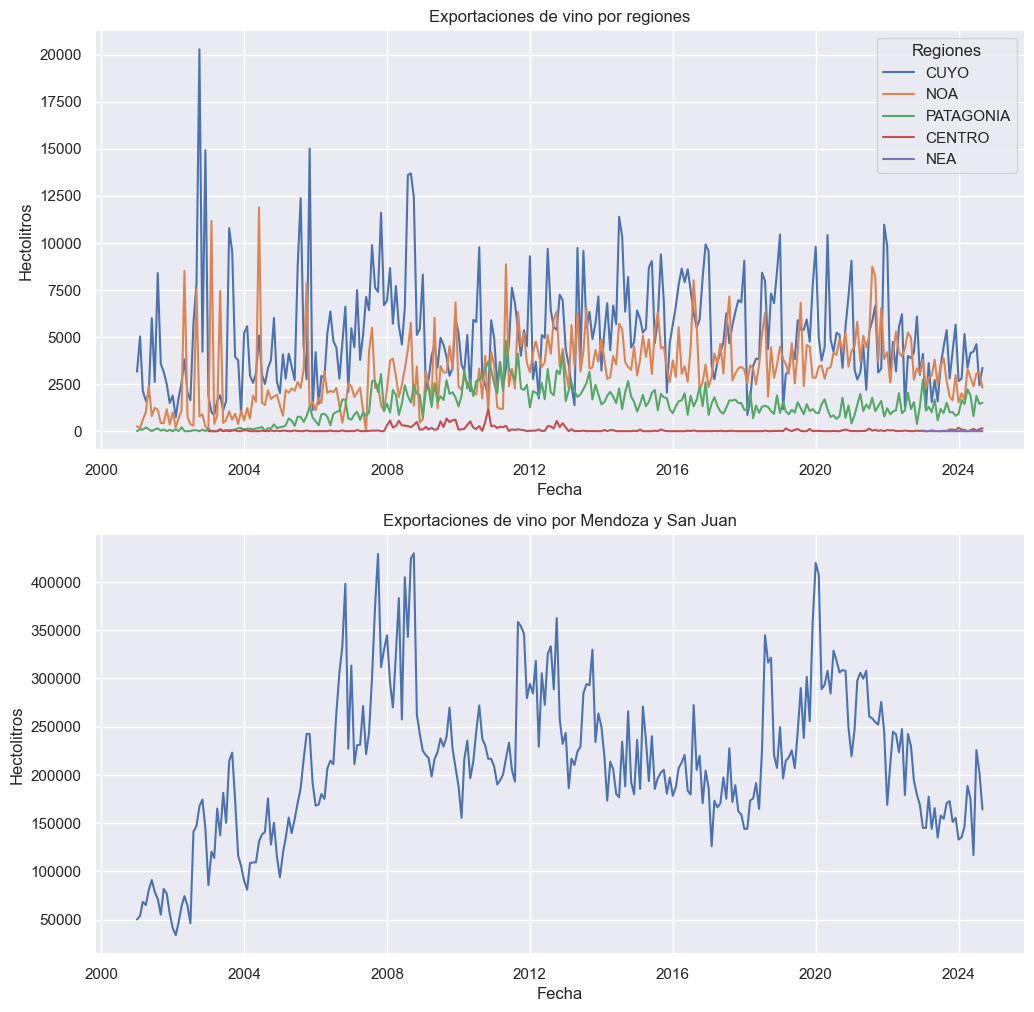

In [33]:
region_plot(df_exp_hl, 'Exportaciones de vino por', 'Hectolitros')

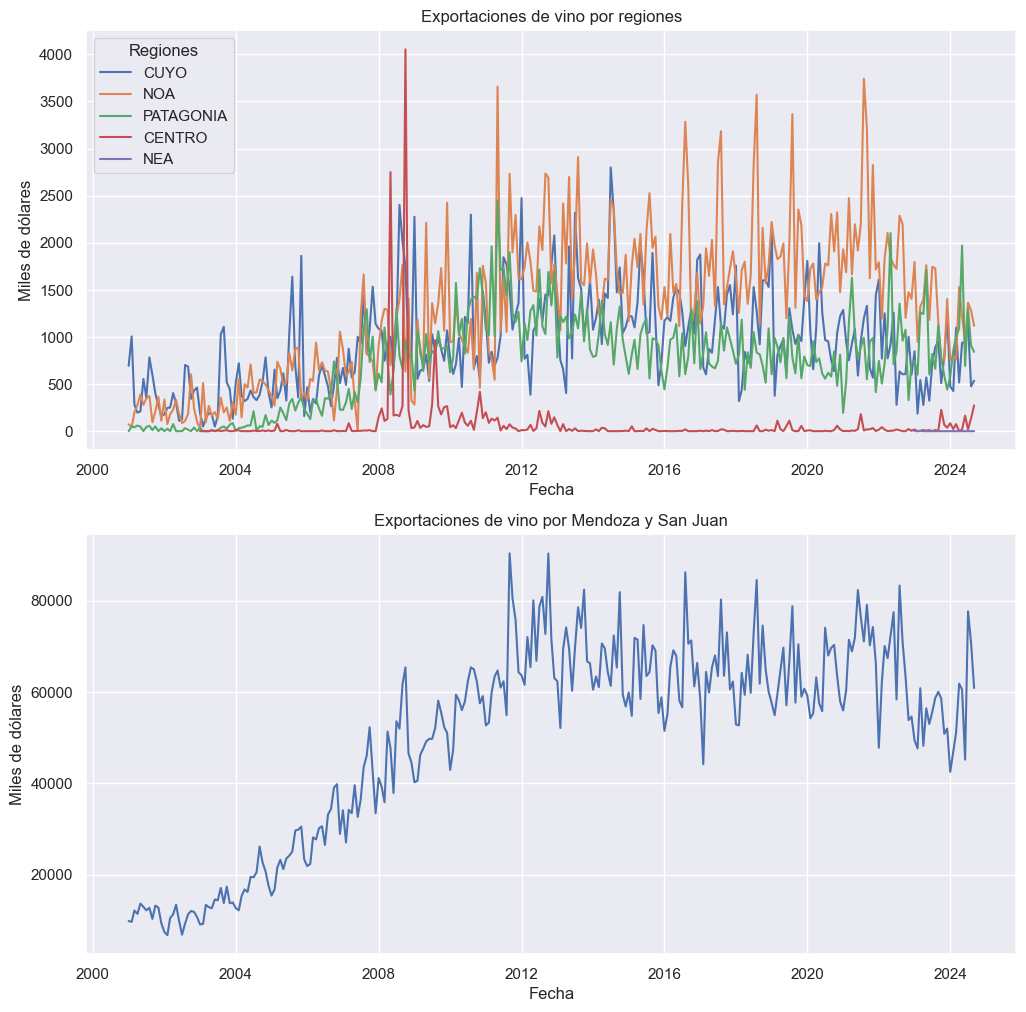

In [34]:
region_plot(df_exp_md, 'Exportaciones de vino por', 'Miles de dólares')

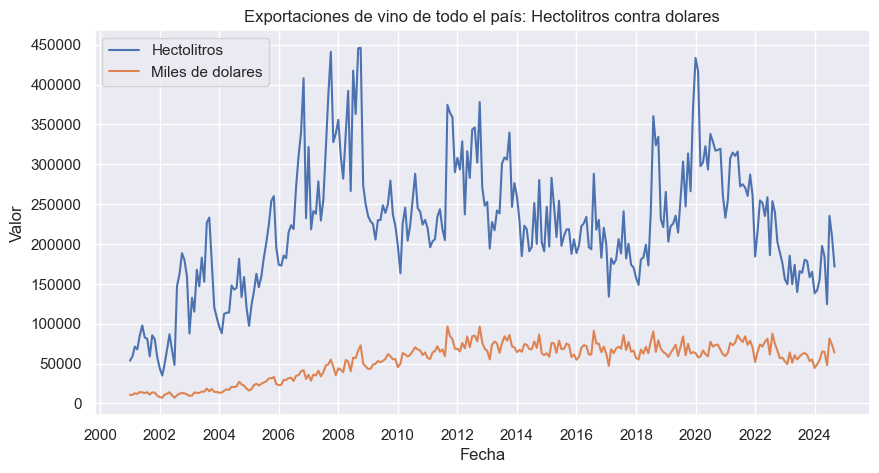

In [16]:
import matplotlib.dates as mdates 
exportaciones_hl = df_exp_hl.groupby('fecha')['valor'].sum()
exportaciones_md = df_exp_md.groupby('fecha')['valor'].sum()
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=exportaciones_hl.index, y=exportaciones_hl, ax=ax, label = 'Hectolitros')
sns.lineplot(x=exportaciones_md.index, y=exportaciones_md, ax=ax, label = 'Miles de dolares')
locator = mdates.YearLocator(2)  # Marca cada 1 año. Cambia a MonthLocator o DayLocator si lo necesitas.
plt.gca().xaxis.set_major_locator(locator)
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.yticks(np.arange(0, 500000, 50000))
plt.title('Exportaciones de vino de todo el país: Hectolitros contra dolares')
plt.show()


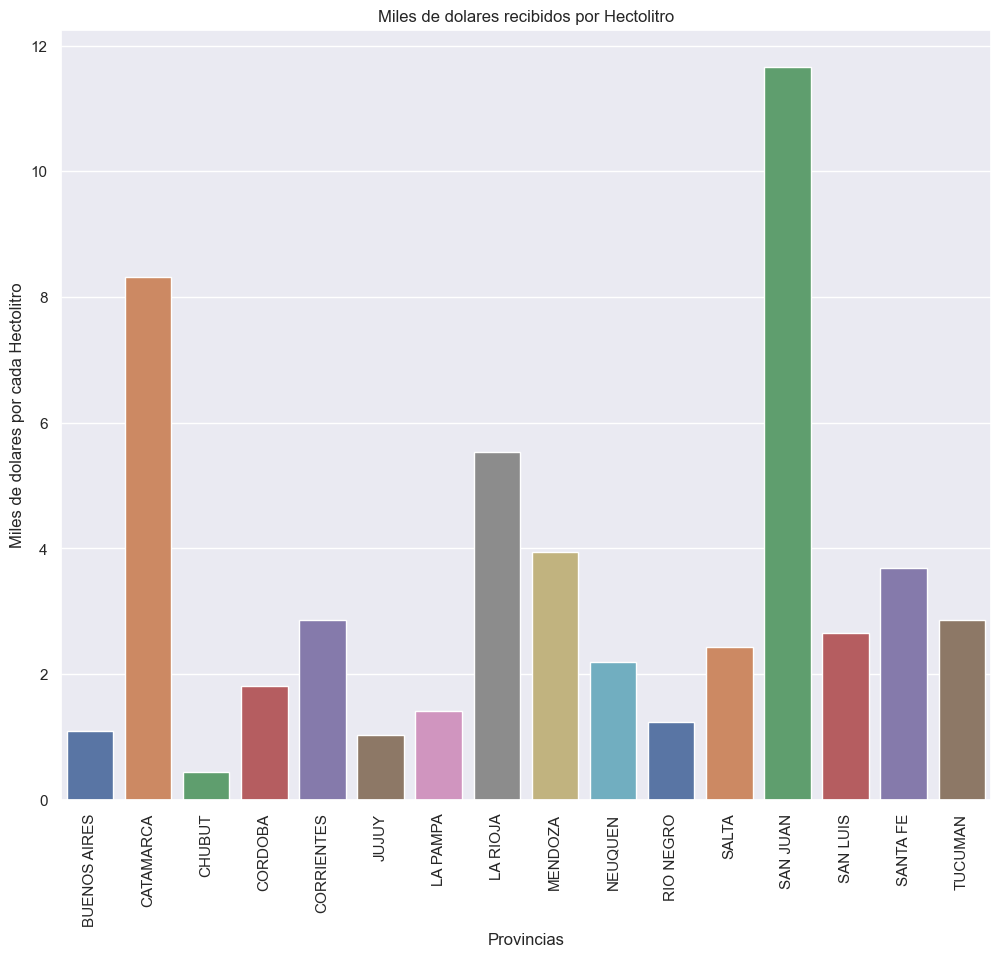

In [17]:
hl = df_exp_hl.groupby('alcance_nombre')['valor'].sum()
md = df_exp_md.groupby('alcance_nombre')['valor'].sum()
hl_exportados_contra_dolares_recibidos = hl / md

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x=hl_exportados_contra_dolares_recibidos.index, 
            y=hl_exportados_contra_dolares_recibidos, 
            hue= hl_exportados_contra_dolares_recibidos.index, 
            legend=False, 
            palette="deep")
plt.xticks(rotation=90)
plt.xlabel("Provincias")
plt.ylabel("Miles de dolares por cada Hectolitro")
plt.title("Miles de dolares recibidos por Hectolitro")
plt.show()

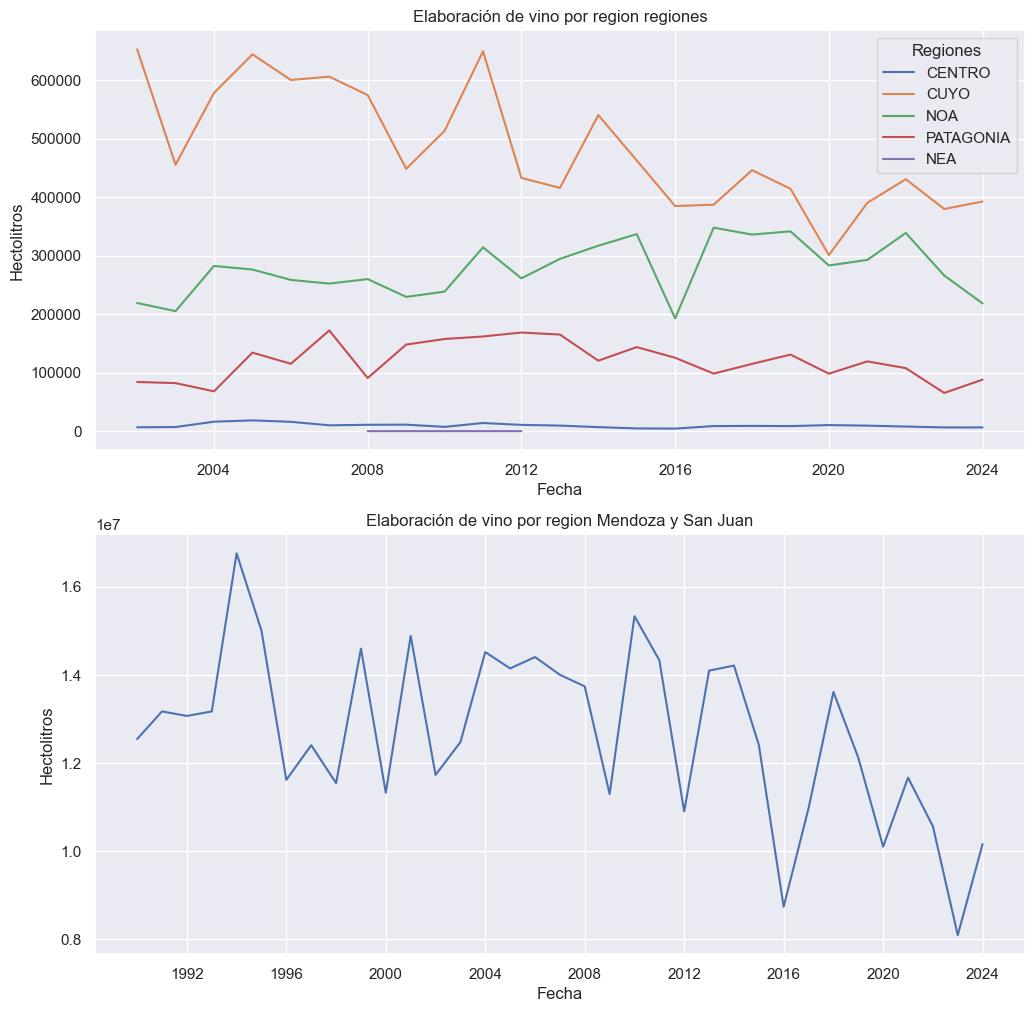

In [19]:
df_elab_vino = df_elab[df_elab['actividad_producto_nombre'] == 'Vino']
region_plot(df_elab_vino, 'Elaboración de vino por region', 'Hectolitros')

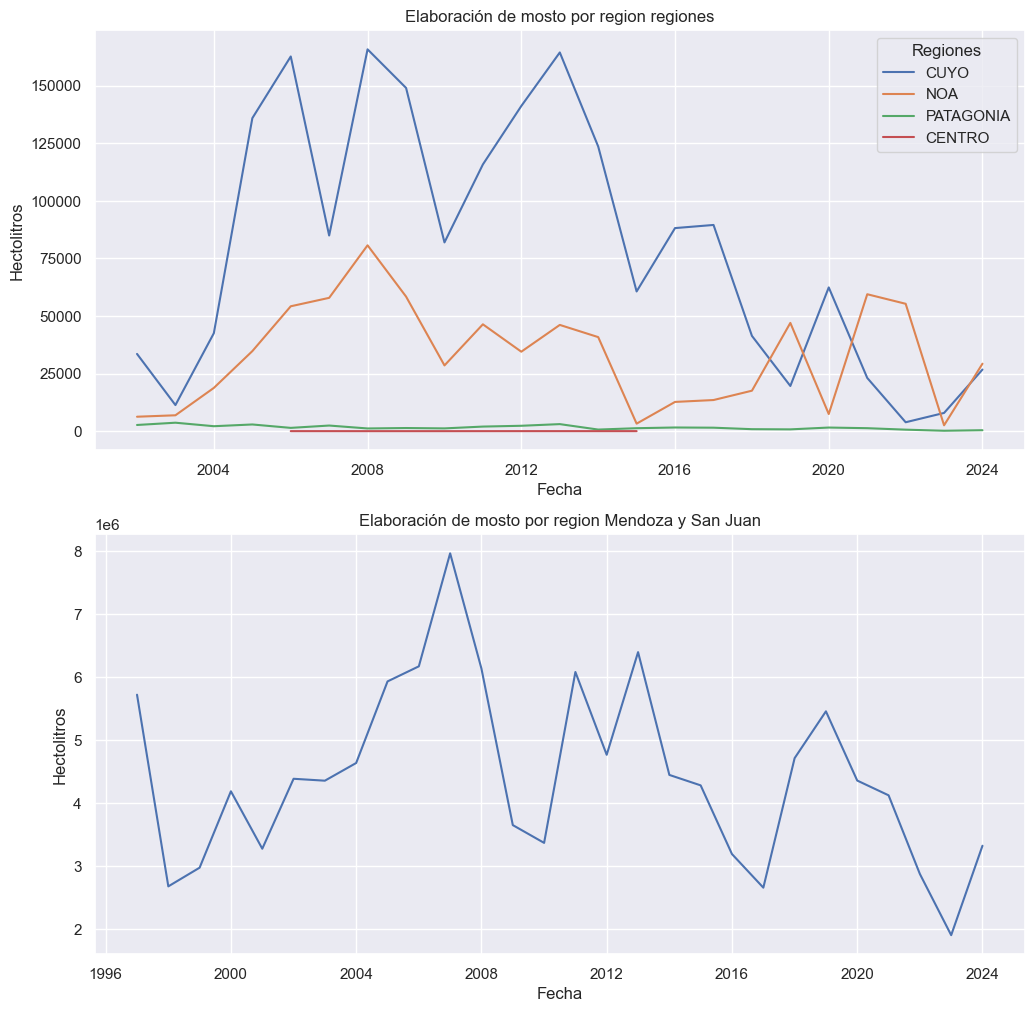

In [20]:
df_elab_mosto = df_elab[df_elab['actividad_producto_nombre'] == 'Mosto']
region_plot(df_elab_mosto, 'Elaboración de mosto por region', 'Hectolitros')

Text(0, 0.5, 'Toneladas')

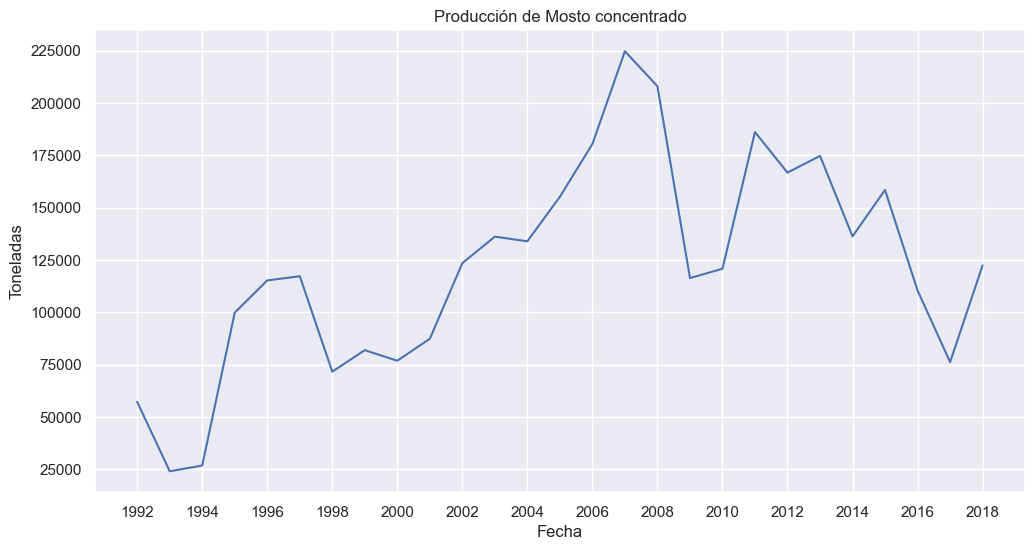

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x="fecha", y="valor", data=df_prod)
year_locator = mdates.YearLocator(2)
plt.gca().xaxis.set_major_locator(locator)
plt.title("Producción de Mosto concentrado")
plt.xlabel("Fecha")
plt.ylabel("Toneladas")

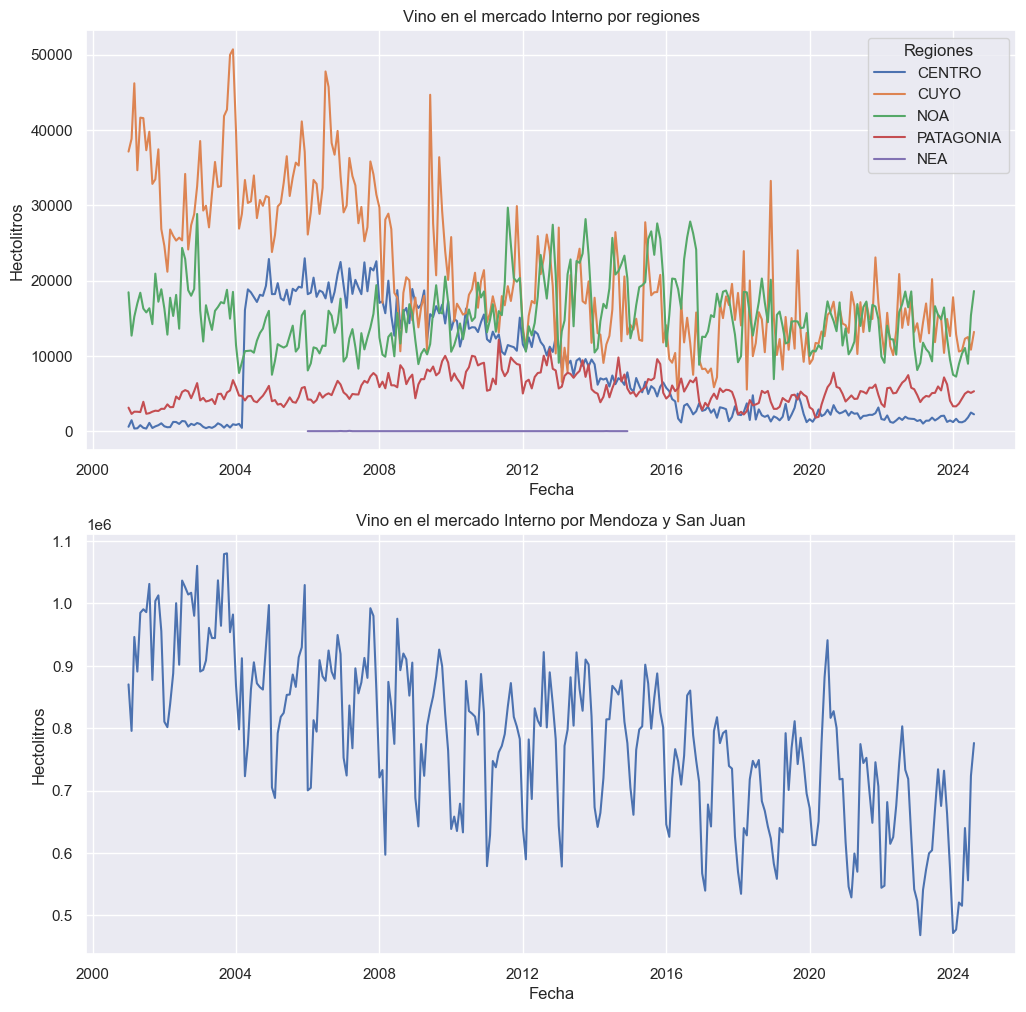

In [22]:
region_plot(df_int, 'Vino en el mercado Interno por', 'Hectolitros')

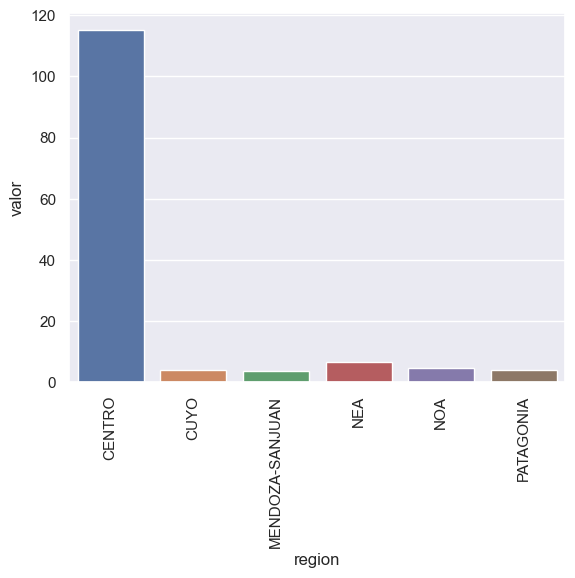

In [23]:
ratio_exportaciones_minterno = df_int.groupby('region')['valor'].sum() / df_exp_hl.groupby('region')['valor'].sum()
sns.barplot(x=ratio_exportaciones_minterno.index, y=ratio_exportaciones_minterno, hue=ratio_exportaciones_minterno.index)
plt.xticks(rotation=90)
plt.show()

In [70]:
exp_mendoza = df.copy()
exp_mendoza = exp_mendoza.iloc[df_exp_hl.index]
exp_mendoza = exp_mendoza[exp_mendoza['alcance_nombre'] == 'MENDOZA']
time_series = exp_mendoza.loc[:,['fecha', 'valor']]
time_series.set_index('fecha', inplace=True)
time = np.arange(len(time_series.index)) 
time_series['time'] = time
time_series['lag_1'] = time_series['valor'].shift(1)
time_series = time_series.dropna()

In [71]:
from sklearn.linear_model import LinearRegression
X = time_series[['lag_1', 'valor']].copy()
y = X.pop('valor')
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

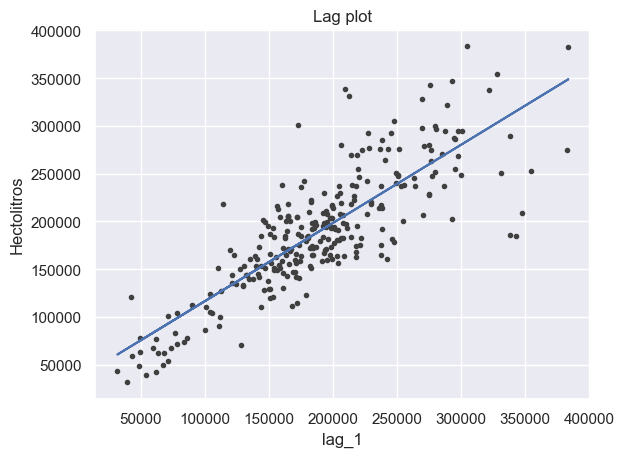

In [72]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(ylabel='Hectolitros', xlabel='lag_1', title='Lag plot');